In [1]:
import numpy as np
import site, pprint, math, re, numpy
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import RidgeCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from lxdr import LXDR
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity as cd, euclidean_distances as ed

For this use case we will use a heart related dataset, specifically for cholesterol. We will reduce the dimensions of the data, we will train a regression model, and using LXDR we will try, end-to-end, to explain a prediction.

As used by Kilpatrick, D. & Cameron-Jones, M. (1998). Numeric prediction using instance-based learning with encoding length selection. In Progress in Connectionist-Based Information Systems. Singapore: Springer-Verlag.

In [2]:
from sklearn.datasets import fetch_openml
df = fetch_openml(data_id='204')
#https://www.openml.org/search?type=data&status=active&id=204

In [ ]:
df.data["sex"] = df.data["sex"].astype('float')
df.data["cp"] = df.data["cp"].astype('float')
df.data["fbs"] = df.data["fbs"].astype('float')
df.data["restecg"] = df.data["restecg"].astype('float')
df.data["exang"] = df.data["exang"].astype('float')
df.data["slope"] = df.data["slope"].astype('float')
df.data["thal"] = df.data["thal"].replace(float(np.nan), np.nan).astype('float')

X = df.data.values
y = df.target.values
feature_names = df.feature_names
target_name = df.target_names

We will MinMaxScale our data! We will scale them to 0.1, 1, as 0 woyld nullify the importance of a few features.

In [5]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler = MinMaxScaler((0.1,1))

In [6]:
X_train_o, X_test_o, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
imp.fit(X_train_o)
X_train_o = imp.transform(X_train_o)
X_test_o = imp.transform(X_test_o)

In [8]:
scaler.fit(X_train_o)
X_train = scaler.transform(X_train_o)
X_test = scaler.transform(X_test_o)

We train the ridge model without reduction!

In [9]:
clf_n = RidgeCV(alphas=(0.01, 100.0, 1)).fit(X_train, y_train)
mae_n = mean_absolute_error(y_test, clf_n.predict(X_test))
rmse_n = mean_squared_error(y_test, clf_n.predict(X_test), squared=False)
print('No DR:', mae_n, rmse_n)

No DR: 43.61383139033333 62.46184738528429


Which features are most influencing? We can see that, as the model is trained on non-reduced data

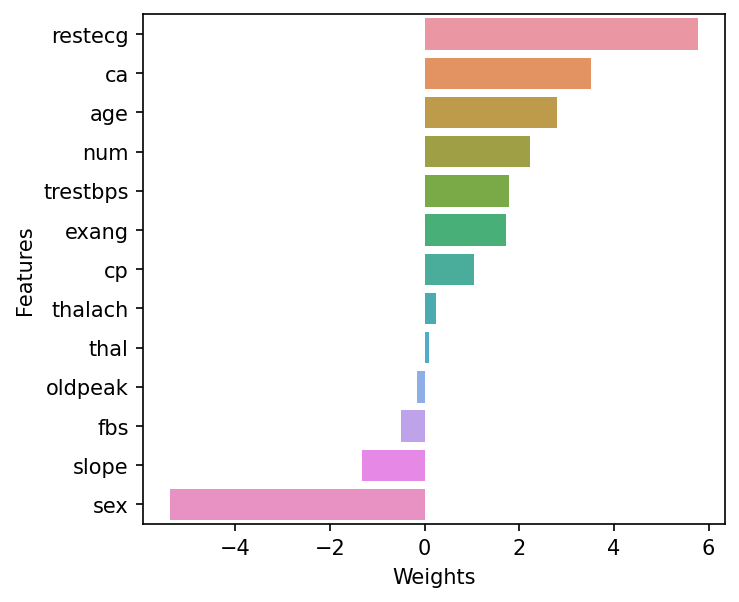

In [10]:
model_weights = pd.DataFrame({"Features": df.feature_names, "Weights": list(clf_n.coef_)}) #If you want to display global structure remove the * INSTANCE
model_weights = model_weights.sort_values(by="Weights", ascending=False)
model_weights = model_weights[(model_weights["Weights"] != 0)]
#Moreover if there are many features you can take head 10 and tail 10 of the dataframe and display only 20 features
plt.figure(num=None, figsize=(5, 4.5), dpi=150, facecolor='w', edgecolor='k')
sns.barplot(x="Weights", y="Features", data=model_weights)
plt.xticks(rotation=0)
plt.show()

We reduce the data to 3 dimensions, with both PCA and KPCA!

In [11]:
pca = PCA(3, random_state=42)
pca.fit(X_train)
pca_train = pca.transform(X_train)
pca_test  = pca.transform(X_test)

In [12]:
sum(pca.explained_variance_ratio_)

0.587302961237434

In [95]:
kpca = KernelPCA(3, kernel='rbf', gamma=0.01, random_state=42)
kpca.fit(X_train)
kpca_train = kpca.transform(X_train)
kpca_test  = kpca.transform(X_test)

In [96]:
clf_p = RidgeCV(alphas=(0.01, 100.0, 1.0)).fit(pca_train, y_train)
clf_k = RidgeCV(alphas=(0.01, 100.0, 1.0)).fit(kpca_train, y_train)

And we check the performance, which is slighlty better than the original!

In [97]:
mae_p = mean_absolute_error(y_test, clf_p.predict(pca_test))
rmse_p  = mean_squared_error(y_test, clf_p.predict(pca_test), squared=False)
mae_k = mean_absolute_error(y_test, clf_k.predict(kpca_test))
rmse_k  = mean_squared_error(y_test, clf_k.predict(kpca_test), squared=False)
print('PCA: ', mae_p, rmse_p)
print('KPCA:', mae_k, rmse_k)

PCA:  41.92670350740053 60.76539498275327
KPCA: 41.909430886377514 60.740649999349934


But how the innput features influence the model? We do not know!

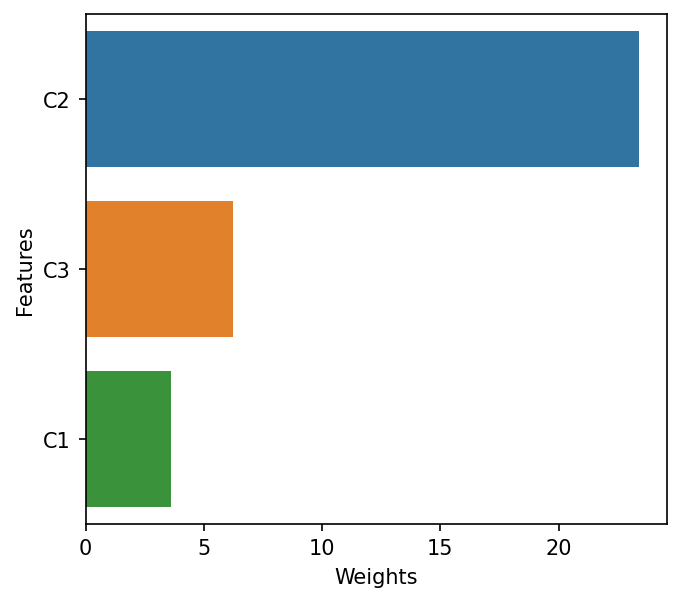

In [16]:
model_weights = pd.DataFrame({"Features": ['C1','C2','C3'], "Weights": list(clf_p.coef_)}) #If you want to display global structure remove the * INSTANCE
model_weights = model_weights.sort_values(by="Weights", ascending=False)
model_weights = model_weights[(model_weights["Weights"] != 0)]
#Moreover if there are many features you can take head 10 and tail 10 of the dataframe and display only 20 features
plt.figure(num=None, figsize=(5, 4.5), dpi=150, facecolor='w', edgecolor='k')
sns.barplot(x="Weights", y="Features", data=model_weights)
plt.xticks(rotation=0)
plt.show()

In PCA, we have the weights of the components. Thus, we can inverse transform the weights to the original dimensions!

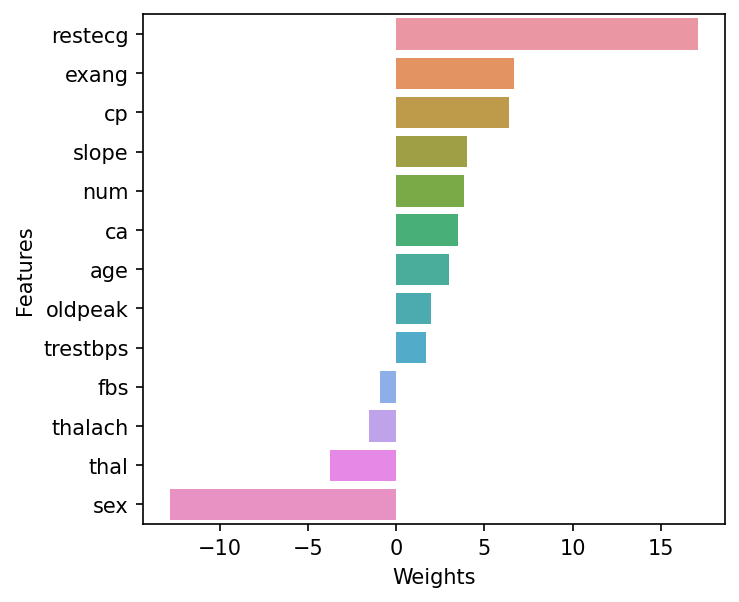

In [18]:
mean = X_train.mean(axis=0)
model_weights = pd.DataFrame({"Features": df.feature_names, "Weights": list(np.dot(clf_p.coef_,pca.components_)+mean)}) 
model_weights = model_weights.sort_values(by="Weights", ascending=False)
model_weights = model_weights[(model_weights["Weights"] != 0)]
#Moreover if there are many features you can take head 10 and tail 10 of the dataframe and display only 20 features
plt.figure(num=None, figsize=(5, 4.5), dpi=150, facecolor='w', edgecolor='k')
sns.barplot(x="Weights", y="Features", data=model_weights)
plt.xticks(rotation=0)
plt.show()

Now, we will test the faithfulness and truthfulness scores, when LXDR tried to approximate PCA's weights.

In [65]:
pred = clf_p.predict(pca_test)

avg_faith = []
avg_instance_diff = []
avg_truth = []
mean = X_train.mean(axis=0)

lxdr = LXDR(pca, feature_names, X_train, mean, ltype = 'classic')
lxdr._set_knn()

for sample in range(len(X_test)):
    components_ = lxdr.explain_instance(X_test[sample], number_of_neighbours=181, auto_alpha=True, ng_technique= 'KNN')
    a = pca_test[sample]
    b = np.dot(X_test[sample]-mean, components_.T)
    avg_instance_diff.append(ed([a],[b])[0][0])
    
    a = clf_p.coef_#*pca_test[sample]
    a = np.dot(a,components_)+mean
    #a = np.dot(a,pca.components_)+mean
    a = a.tolist()*X_test[sample]
    
    #Faith:
    ma = np.argmax(a)
    temp_sample = X_test[sample].copy()
    if temp_sample[ma] > 0:
        temp_sample[ma] = 0
        w = 1
    elif temp_sample[ma] < 0:
        temp_sample[ma] = 0
        w = -1
    elif temp_sample[ma] == 0:
        temp_sample[ma] = 1
        w = -1
    pca_sample = pca.transform([temp_sample])
    temp_pred = clf_p.predict(pca_sample)[0]
    if a[ma] > 0:
        avg_faith.append(w*(pred[sample]-temp_pred))
    elif a[ma] < 0:
        avg_faith.append(w*(temp_pred-pred[sample]))
    else:
        avg_faith.append((-1)*abs(w*(temp_pred-pred[sample])))       

    #Truth:
    truth = []
    for k in range(len(X_test[sample])):
        temp_sample = X_test[sample].copy()
        if temp_sample[k] > 0:
            temp_sample[k] = 0
            w = 1
        elif temp_sample[k] < 0:
            temp_sample[k] = 0
            w = -1
        elif temp_sample[k] == 0:
            temp_sample[k] = 1
            w = -1
        pca_sample = pca.transform([temp_sample])
        temp_pred = clf_p.predict(pca_sample)[0]
        if a[k] > 0 and w*(pred[sample]-temp_pred)>0:
            truth.append(1)
        elif a[k] < 0 and w*(pred[sample]-temp_pred)<0:
            truth.append(1)
        elif a[k] == 0 and pred[sample]==temp_pred:
            truth.append(1)

    avg_truth.append(np.array(truth).sum()/len(X_test[sample]))
print(np.array(avg_faith).mean(), np.array(avg_instance_diff).mean(), np.array(avg_truth).mean())

10.585118968044776 2.6117262147630325e-05 1.0


Let's do the same for KPCA, where the coefficients are not available, and thus, LXDR is our only option!

In [77]:
pred = clf_k.predict(kpca_test)
for typ in ['classic', 'locallocal']:
    lxdr = LXDR(kpca, feature_names, X_train, False, ltype = typ)
    if typ == 'classic':
        lxdr._set_knn()
        lxdr._set_knn_latent()
    else:
        lxdr._set_knn_local()
        lxdr._set_knn_latent_local()
    for ng_technique in ["KNN", "LatentKNN", "Clustering"]:
        for neighs in [10, 50, 100, 181]:
            avg_faith = []
            avg_truth = []
            avg_instance_diff = []
            for sample in range(len(X_test)):
                components_ = lxdr.explain_instance(X_test[sample], number_of_neighbours=neighs, auto_alpha=True, ng_technique=ng_technique)
                a = kpca_test[sample]
                b = np.dot(X_test[sample], components_.T)
                avg_instance_diff.append(ed([a],[b])[0][0])

                a = clf_k.coef_#*kpca_test[sample]
                a = np.dot(a,components_)
                a = a.tolist()*X_test[sample]

                #Faith:
                ma = np.argmax(a)
                temp_sample = X_test[sample].copy()
                if temp_sample[ma] > 0:
                    temp_sample[ma] = 0
                    w = 1
                elif temp_sample[ma] < 0:
                    temp_sample[ma] = 0
                    w = -1
                elif temp_sample[ma] == 0:
                    temp_sample[ma] = 1
                    w = -1
                kpca_sample = kpca.transform([temp_sample])
                temp_pred = clf_k.predict(kpca_sample)[0]
                if a[ma] > 0:
                    avg_faith.append(w*(pred[sample]-temp_pred))
                elif a[ma] < 0:
                    avg_faith.append(w*(temp_pred-pred[sample]))
                else:
                    avg_faith.append((-1)*abs(w*(temp_pred-pred[sample])))       

                #Truth:
                truth = []
                for k in range(len(X_test[sample])):
                    temp_sample = X_test[sample].copy()
                    if temp_sample[k] > 0:
                        temp_sample[k] = 0
                        w = 1
                    elif temp_sample[k] < 0:
                        temp_sample[k] = 0
                        w = -1
                    elif temp_sample[k] == 0:
                        temp_sample[k] = 1
                        w = -1
                    kpca_sample = kpca.transform([temp_sample])
                    temp_pred = clf_k.predict(kpca_sample)[0]
                    if a[k] > 0 and w*(pred[sample]-temp_pred)>0:
                        truth.append(1)
                    elif a[k] < 0 and w*(pred[sample]-temp_pred)<0:
                        truth.append(1)
                    elif a[k] == 0 and pred[sample]==temp_pred:
                        truth.append(1)

                avg_truth.append(np.array(truth).sum()/len(X_test[sample]))
            print(typ, ng_technique, neighs, round(np.array(avg_faith).mean(),4), round(np.array(avg_instance_diff).mean(),4), round(np.array(avg_truth).mean(),4))

classic KNN 10 7.0203 0.0005 0.8096
classic KNN 50 10.6265 0.0107 0.9369
classic KNN 100 10.5977 0.0152 0.9256
classic KNN 181 10.6071 0.0164 0.9206
classic LatentKNN 10 5.1849 0.0004 0.8184
classic LatentKNN 50 9.6489 0.0048 0.942
classic LatentKNN 100 10.6071 0.0133 0.9306
classic LatentKNN 181 10.6071 0.0158 0.918
classic Clustering 10 6.0891 0.0003 0.773
classic Clustering 50 10.5421 0.0012 0.9407
classic Clustering 100 10.5228 0.0125 0.9231
classic Clustering 181 10.5803 0.0175 0.9231
locallocal KNN 10 7.0203 0.0005 0.8096
locallocal KNN 50 10.6265 0.0108 0.9369
locallocal KNN 100 10.5977 0.0152 0.9256
locallocal KNN 181 10.6071 0.0164 0.9206
locallocal LatentKNN 10 5.0471 0.0005 0.715
locallocal LatentKNN 50 7.0127 0.0064 0.8903
locallocal LatentKNN 100 10.2664 0.0126 0.9155
locallocal LatentKNN 181 10.6071 0.016 0.9231
locallocal Clustering 10 6.0891 0.0003 0.7743
locallocal Clustering 50 10.5421 0.0012 0.9407
locallocal Clustering 100 10.5228 0.0125 0.9231
locallocal Clustering

Now, we choose an instance to experiment with!

In [20]:
X_test[0]

array([0.55      , 1.        , 0.7       , 0.40566038, 1.        ,
       1.        , 0.80076336, 0.1       , 0.1       , 0.1       ,
       1.        , 0.1       , 0.1       ])

In [21]:
X_test_o[0]

array([ 53.,   1.,   3., 130.,   1.,   2., 173.,   0.,   0.,   1.,   3.,
         3.,   0.])

This instance has the following prediction:

In [23]:
clf_k.predict(kpca_test)[0], y_test[0]

(247.44337503250617, 246.0)

Initialize LXDR

In [ ]:
lxdr = LXDR(kpca, feature_names, X_train, False, ltype = 'classic')
lxdr._set_knn_latent()
components_ = lxdr.explain_instance(X_test[0], number_of_neighbours=50, auto_alpha=True, ng_technique='LatentKNN')

Use the produced weights to transform the weights from the reduced to the original space!

In [83]:
a = clf_k.coef_
a = np.dot(a,components_)
a = a.tolist()*X_test[0]

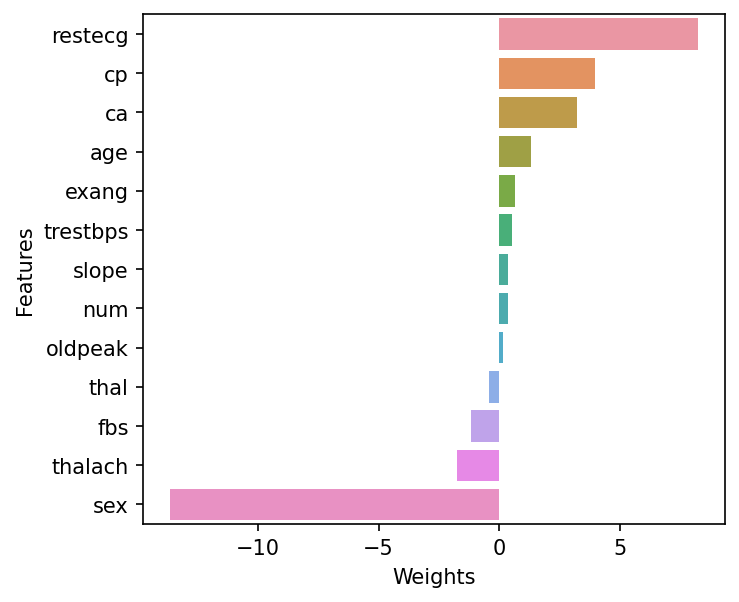

In [84]:
model_weights = pd.DataFrame({"Features": feature_names, "Weights": list(a)}) 
model_weights = model_weights.sort_values(by="Weights", ascending=False)
model_weights = model_weights[(model_weights["Weights"] != 0)]
#Moreover if there are many features you can take head 10 and tail 10 of the dataframe and display only 20 features
plt.figure(num=None, figsize=(5, 4.5), dpi=150, facecolor='w', edgecolor='k')
sns.barplot(x="Weights", y="Features", data=model_weights)
plt.xticks(rotation=0)
plt.show()

In [28]:
copy_X_test_o = X_test_o.copy()
copy_X_test_o[0][5] = 0

In [29]:
scaled_c = scaler.transform([copy_X_test_o[0]])
reduced_c = kpca.transform(scaled_c)
clf_k.predict(reduced_c)

array([232.4803562])

We can also present in a 3d plot our instances

No handles with labels found to put in legend.


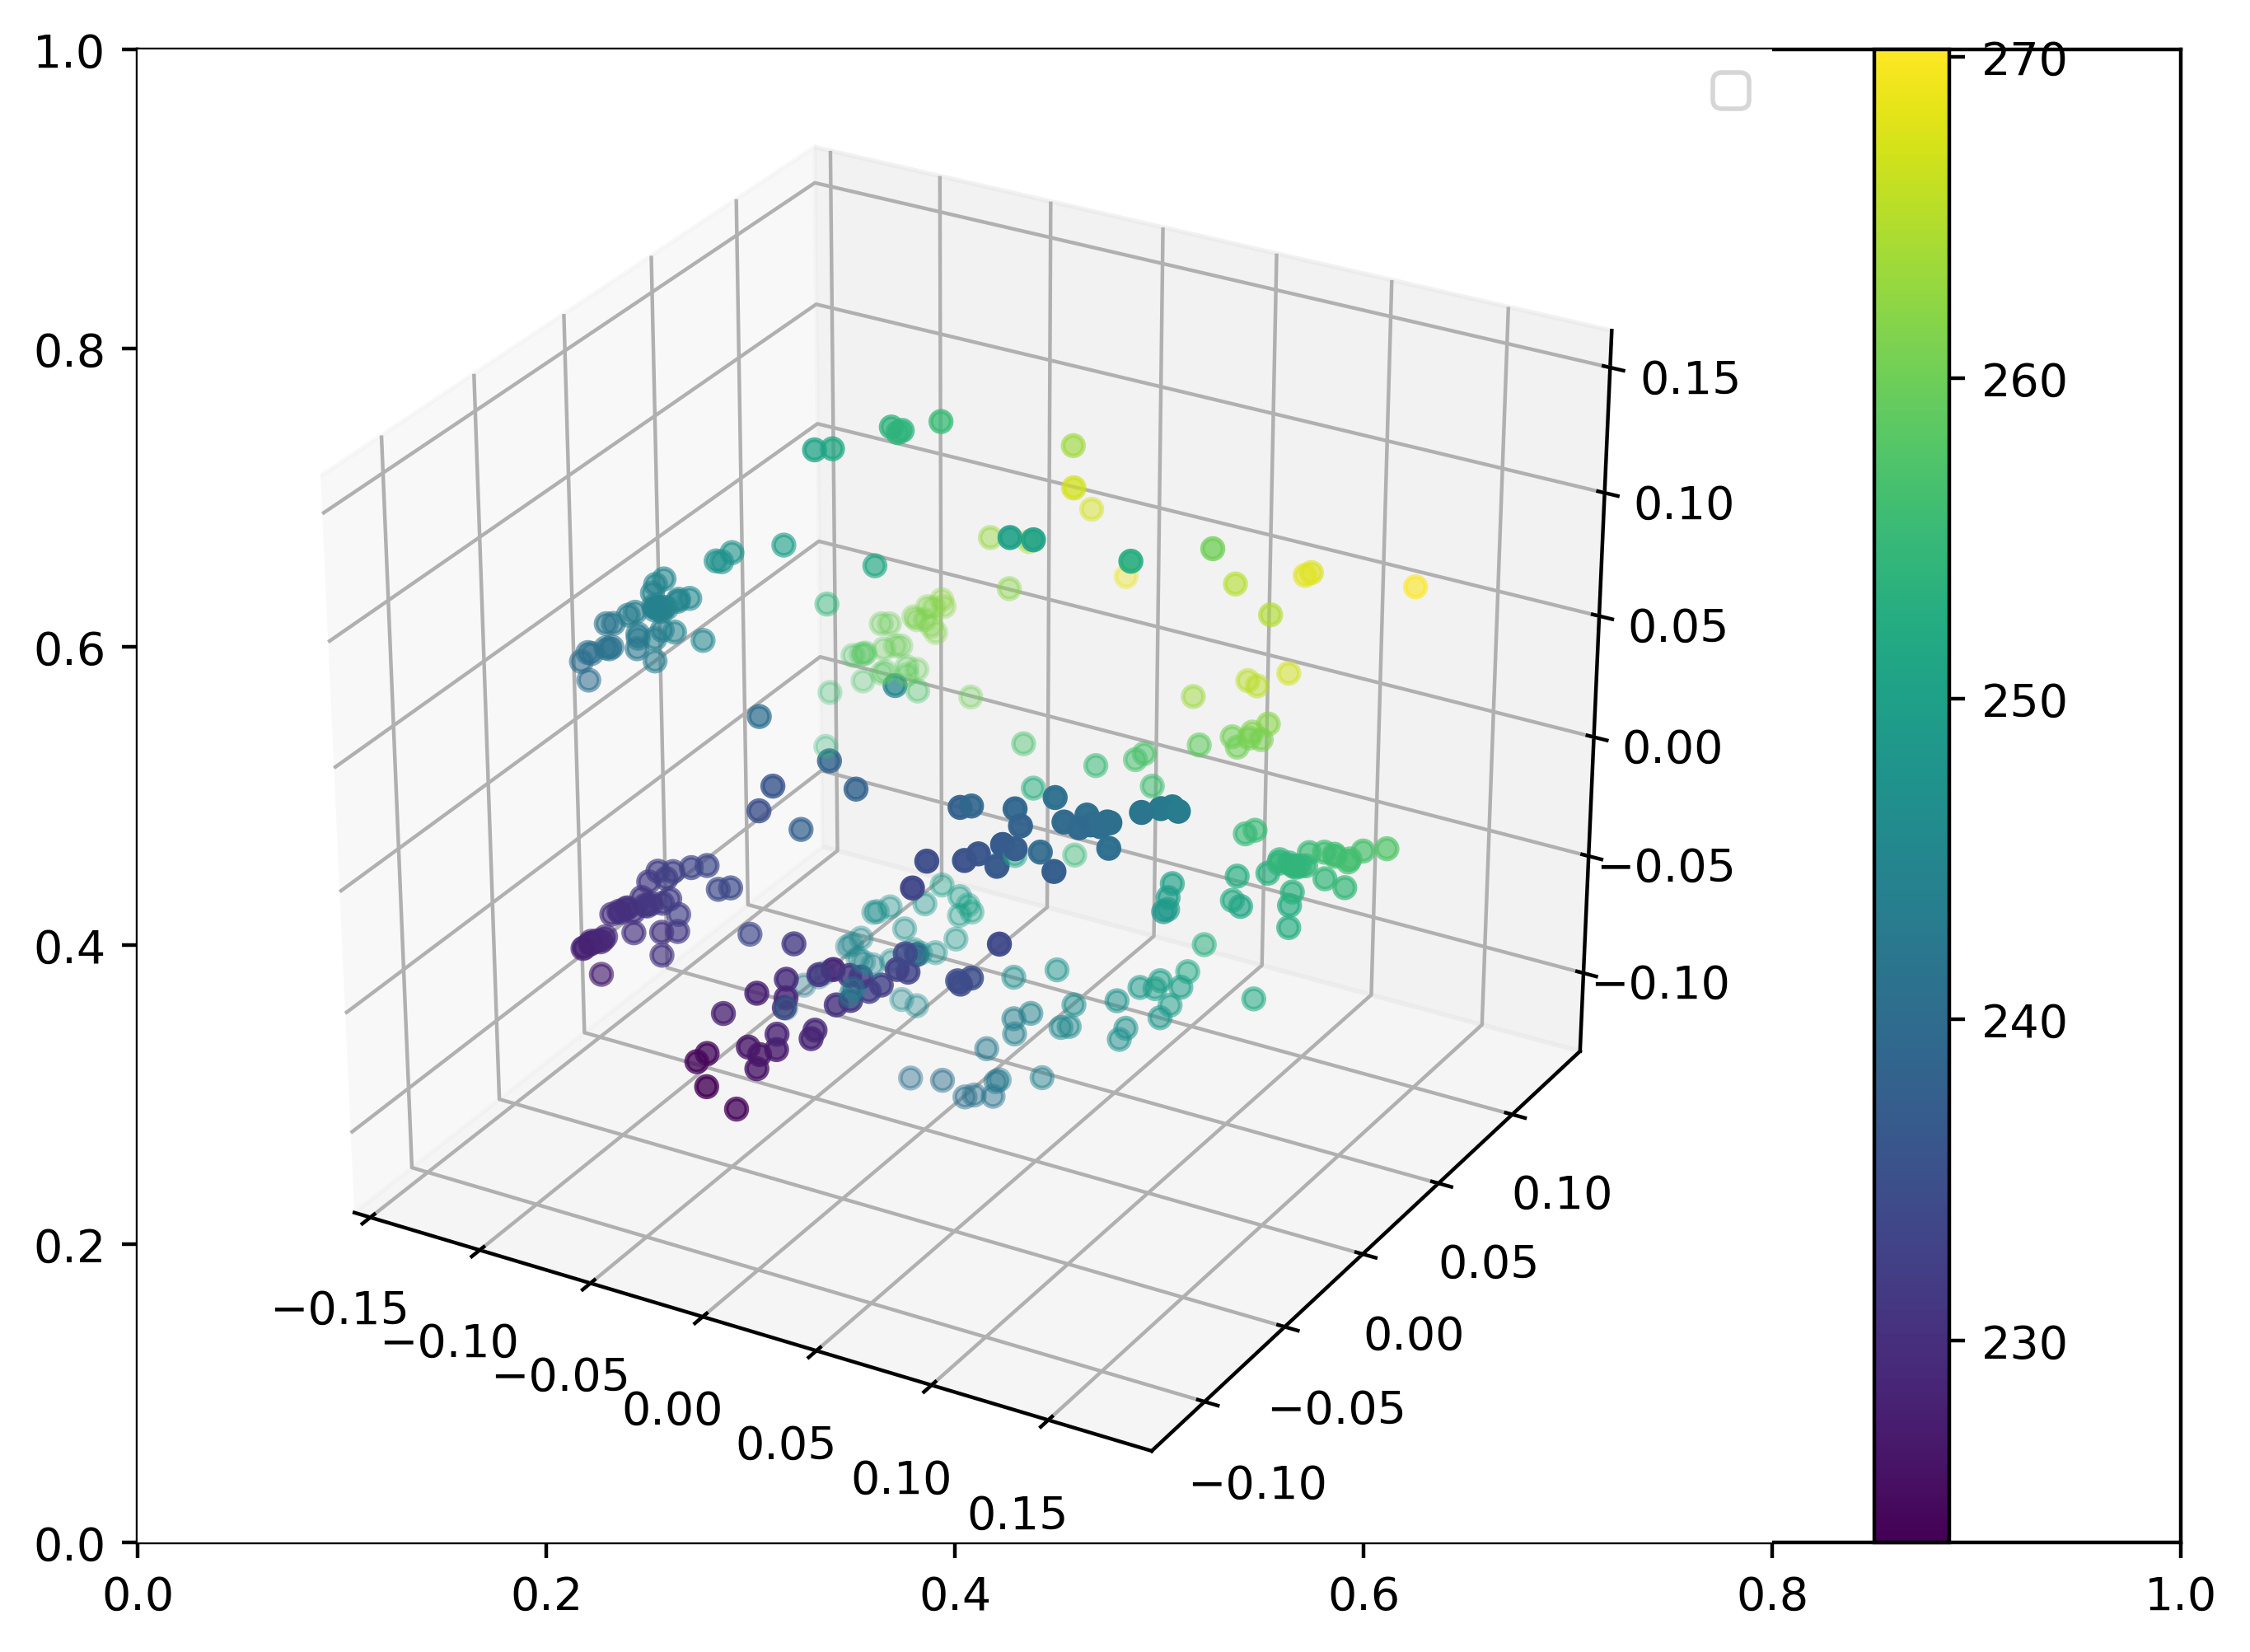

In [98]:
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=400, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
df = pd.DataFrame(np.concatenate((kpca_train,kpca_test)), columns=['x', 'y','z'])
points = ax.scatter(df.x, df.y, df.z, c=clf_k.predict(np.concatenate((kpca_train,kpca_test))))
plt.colorbar(points)
ax.legend()
#plt.show()

In [33]:
df = pd.DataFrame(np.concatenate((kpca_train,kpca_test)), columns=['C1', 'C2','C3'])
df['predictions'] = clf_k.predict(np.concatenate((kpca_train,kpca_test)))
df['ground truth'] = np.concatenate((y_train,y_test))
df['id'] = df.index
df2 = pd.DataFrame(np.concatenate((X_train_o,X_test_o)), columns=feature_names)

In [100]:
df = pd.DataFrame(kpca_test, columns=['C1', 'C2','C3'])
df['predictions'] = clf_k.predict(kpca_test)
df['ground truth'] = y_test
df['id'] = df.index
df2 = pd.DataFrame(X_test_o, columns=feature_names)

In [101]:
import plotly.express as px
fig = px.scatter_3d(pd.concat([df,df2],axis=1), x='C1', y='C2', z='C3',
                    color=df['predictions'], hover_data=['id', 'ground truth'])
fig.show()

In [102]:
components_ = lxdr.explain_instance(X_test[28], number_of_neighbours=50, auto_alpha=True, ng_technique='LatentKNN')

In [121]:
copy_X_test_o = X_test[28].copy()
copy_X_test_o[7] = 0
scaled_c = scaler.transform([copy_X_test_o])
reduced_c = kpca.transform(scaled_c)
clf_k.predict(reduced_c)

array([244.09158073])

In [122]:
copy_kpca_test = kpca_test.copy()
copy_kpca_test[28] = reduced_c

df = pd.DataFrame(copy_kpca_test, columns=['C1', 'C2','C3'])
df['predictions'] = clf_k.predict(copy_kpca_test)#clf_k.predict(kpca_test)
df['ground truth'] = y_test
df['id'] = df.index
df2 = pd.DataFrame(X_test_o, columns=feature_names)

In [123]:
import plotly.express as px
fig = px.scatter_3d(pd.concat([df,df2],axis=1), x='C1', y='C2', z='C3',
                    color=df['predictions'], hover_data=['id', 'ground truth'])
fig.show()